In [2]:
import numpy as np
import pandas as pd
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats
from datetime import date

In [3]:
from hyperopt import hp
from hyperopt import Trials

try:
    from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA
except:
    !pip install --upgrade shap-hypetune
    from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA

import warnings
warnings.simplefilter('ignore')

In [25]:
#api = KaggleApi()
#api.authenticate()
#api.competition_download_file("house-prices-advanced-regression-techniques", "train.csv")
#api.competition_download_file("house-prices-advanced-regression-techniques", "test.csv")

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [35]:
#train_df[train_df["Street"] != "Pave"]

In [30]:
#sel = VarianceThreshold(threshold=0)
#sel.fit(train_df.select_dtypes(include=np.number))

In [31]:
#sel = VarianceThreshold(threshold=0.05)  # 0.1 indicates 99% of observations approximately
#sel.fit(train_df.select_dtypes(include=np.number))

In [32]:
#sum(sel.get_support())

In [33]:
#print(
#    len([
#        x for x in train_df.select_dtypes(include=np.number).columns
#        if x not in train_df.select_dtypes(include=np.number).columns[sel.get_support()]
#    ]))
#
#[x for x in train_df.select_dtypes(include=np.number).columns if x not in train_df.select_dtypes(include=np.number).columns[sel.get_support()]]

In [34]:
#pd.set_option('display.max_columns', None)
#train_df.describe(include='all')

In [99]:
train_df["SalePrice"].sort_values()

495      34900
916      35311
968      37900
533      39300
30       40000
         ...  
803     582933
898     611657
1169    625000
1182    745000
691     755000
Name: SalePrice, Length: 1460, dtype: int64

In [100]:
train_df = train_df[train_df["SalePrice"]<700000]

In [6]:
x = train_df.drop(['Id','SalePrice'],axis=1)
y = np.log(train_df.SalePrice)

sub_x = test_df.drop(['Id'],axis=1)

In [7]:
x.loc[:, x.isnull().mean() > 0.1].columns

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [8]:
x.drop(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence'],axis=1,inplace= True)
sub_x.drop(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence'],axis=1,inplace= True)

In [9]:
x.shape, sub_x.shape

((1460, 74), (1459, 74))

In [10]:
def Make_Features(df, feat_lst):
      
    # Calculating total bathrooms:-    
    df['Tot_Baths'] = df.FullBath + df.BsmtFullBath + ((df.HalfBath + df.BsmtHalfBath) * 0.5);
 
    # Calculating total basement square feet area:-
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['BsmtUnfSF']);
    
    # Calculating total property area:-    
    df['Prop_Area'] = (df.TotalBsmtSF.fillna(0) + df.WoodDeckSF.fillna(0) + df.GrLivArea.fillna(0) +df['3SsnPorch'].fillna(0)+
                       df.OpenPorchSF.fillna(0) + df.ScreenPorch.fillna(0) + df.EnclosedPorch.fillna(0) +
                       df.MasVnrArea.fillna(0) + df.GarageArea.fillna(0) + df.PoolArea.fillna(0));
    
    #  Calculating all porch and wood decks:-   
    df['Porch_WdDeck'] = \
    df.OpenPorchSF + df.EnclosedPorch.fillna(0) + df.ScreenPorch.fillna(0) + df.WoodDeckSF.fillna(0) + df['3SsnPorch'].fillna(0);
        
    #  Calculating flag for pool:-
    df['Pool_Fl'] = np.where(df.PoolArea>0, 1,0);
    
    # Calculating property build-sell cycle and filling year sold nulls:-    
    df['YrSold'] = df['YrSold'].fillna(date.today().year - 1);
    df['Prop_BldSell_Cyc'] = np.clip(df['YrSold'] - df['YearBuilt'], a_min= 0.0, a_max= None);
    
    # Creating flag for remodelling:-
    df['Is_Remodelled'] = np.where(df.YearRemodAdd != df.YearBuilt, 1,0);
    df['MiscFeature'] = np.where(df[['MiscFeature']].isnull(), 0, 1);
    
    # Creating flag for remodelling just before sale:-    
    df['Is_ReMdlB4Sale'] = np.where(abs(df['YrSold'] - df['YearRemodAdd']) <=1, 1, 0);
         
    # Replacing null values in garage year built with year-built:-
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt']);
    
    # Displaying null attributes after the treatment:-  
    _ = df.isna().sum(axis=0);
    del _;
       
    return df

In [11]:
x = Make_Features(x,list(x.columns))
sub_x = Make_Features(sub_x,list(test_df.columns))

In [12]:
x.shape, sub_x.shape

((1460, 81), (1459, 81))

In [13]:
for c in x.columns:
    col_type = x[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        x[c] = x[c].astype('category')
        

for c in sub_x.columns:
    col_type = sub_x[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        sub_x[c] = sub_x[c].astype('category')
        
        
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [14]:
x_train.shape, x_test.shape, y_train.shape , y_test.shape

((1168, 81), (292, 81), (1168,), (292,))

In [55]:
#train_df['FullBath'].value_counts(dropna=False)

In [15]:
import lightgbm as lgb

In [16]:
for_fun = pd.DataFrame (list(x_train.dtypes == "category"), columns = ['kek'])

In [17]:
model = lgb.LGBMRegressor(learning_rate=0.01,objective='regression', n_estimators= 500, metric='rmse',
                          categorical_feature=list(for_fun[(for_fun['kek'] == True)].index), 
                         )

In [18]:
model.fit(x_train, y_train , eval_set = [(x_test,y_test ),(x_train, y_train)], eval_metric='logloss')

[1]	training's rmse: 0.387144	valid_0's rmse: 0.429902
[2]	training's rmse: 0.383873	valid_0's rmse: 0.426566
[3]	training's rmse: 0.380651	valid_0's rmse: 0.4233
[4]	training's rmse: 0.377454	valid_0's rmse: 0.420044
[5]	training's rmse: 0.374305	valid_0's rmse: 0.416859
[6]	training's rmse: 0.371181	valid_0's rmse: 0.413653
[7]	training's rmse: 0.36809	valid_0's rmse: 0.410536
[8]	training's rmse: 0.365025	valid_0's rmse: 0.407329
[9]	training's rmse: 0.361991	valid_0's rmse: 0.404206
[10]	training's rmse: 0.359	valid_0's rmse: 0.401127
[11]	training's rmse: 0.356036	valid_0's rmse: 0.39811
[12]	training's rmse: 0.353091	valid_0's rmse: 0.395098
[13]	training's rmse: 0.350199	valid_0's rmse: 0.392137
[14]	training's rmse: 0.347313	valid_0's rmse: 0.38921
[15]	training's rmse: 0.34447	valid_0's rmse: 0.38622
[16]	training's rmse: 0.34167	valid_0's rmse: 0.383282
[17]	training's rmse: 0.33888	valid_0's rmse: 0.380424
[18]	training's rmse: 0.336127	valid_0's rmse: 0.377537
[19]	training

LGBMRegressor(categorical_feature=[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18,
                                   19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30,
                                   32, 36, 37, 38, 39, 50, ...],
              learning_rate=0.01, metric='rmse', n_estimators=500,
              objective='regression')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

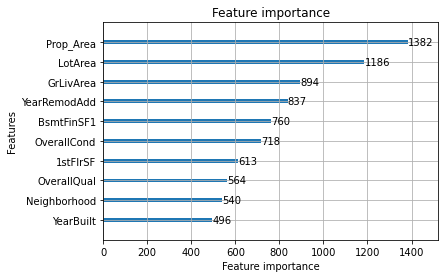

In [19]:
lgb.plot_importance(model, max_num_features = 10)

In [20]:
print('Training score {:.4f}'.format(model.score(x_train,y_train)))
print('Testing score {:.4f}'.format(model.score(x_test,y_test)))

Training score 0.9729
Testing score 0.9012


<AxesSubplot:>

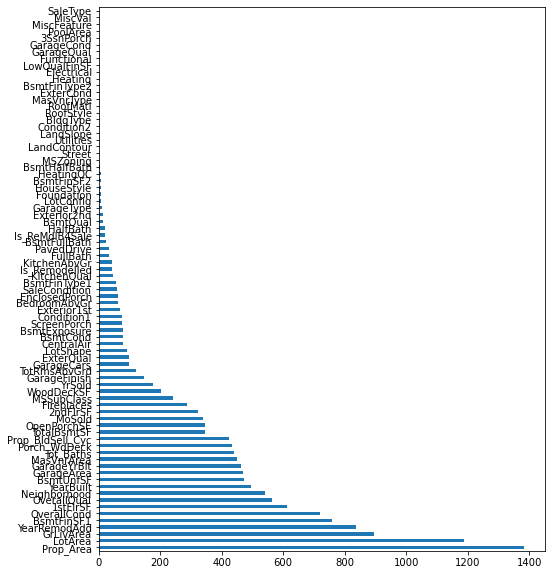

In [21]:
feat_imp = pd.Series(model.feature_importances_, index=x.columns)
feat_imp.nlargest(80).plot(kind='barh', figsize=(8,10))

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

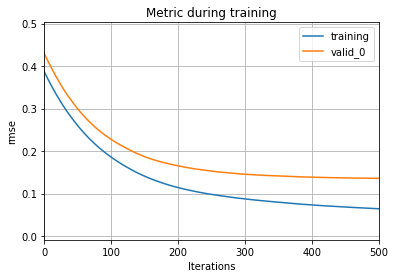

In [22]:
lgb.plot_metric(model)

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(y_test, np.exp(model.predict(x_test))))

193777.411385233

In [177]:
x.shape, sub_x.shape

((1460, 81), (1459, 81))

In [235]:
model.predict(sub_x)

array([11.79663469, 11.96365072, 12.11739664, ..., 12.08505359,
       11.60257976, 12.26043046])

In [182]:
test_df.loc[:,["Id" ,"SalePrice"]].to_csv("sub.csv",index=False)

In [183]:
test_df.loc[:,["Id" ,"SalePrice"]].to_csv("sub.csv",index=False)

In [232]:
#otherstuff
import lightgbm as lgb

In [233]:
training_final = lgb.Dataset(x_train, y_train, categorical_feature=list(for_fun[(for_fun['kek'] == True)].index), free_raw_data=False)

In [234]:
validation_final = lgb.Dataset(x_test, y_test, categorical_feature=list(for_fun[(for_fun['kek'] == True)].index),
                               free_raw_data=False,
                               reference=training_final)

In [33]:
hyper_params = {
    #'task': 'train',
    'objective': 'regression',
    'metric': ['rmse', "mape" ],
    #'categorical_feature' : list(for_fun[(for_fun['kek'] == True)].index)
}

In [34]:
model = lgb.train(hyper_params,
                  train_set = training_final,
                  valid_sets =validation_final,
                  categorical_feature=list(for_fun[(for_fun['kek'] == True)].index),
                  num_boost_round=1200)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3152
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 76
[LightGBM] [Info] Start training from score 181441.541952
[1]	valid_0's rmse: 81194.1	valid_0's mape: 0.378944
[2]	valid_0's rmse: 75504.9	valid_0's mape: 0.347231
[3]	valid_0's rmse: 70272.1	valid_0's mape: 0.319908
[4]	valid_0's rmse: 65741.1	valid_0's mape: 0.29468
[5]	valid_0's rmse: 61532.1	valid_0's mape: 0.272245
[6]	valid_0's rmse: 57926.3	valid_0's mape: 0.252033
[7]	valid_0's rmse: 54743.2	valid_0's mape: 0.234567
[8]	valid_0's rmse: 52002.1	valid_0's mape: 0.218418
[9]	valid_0's rmse: 49590.4	valid_0's mape: 0.204664
[10]	valid_0's rmse: 47427.8	valid_0's mape: 0.19294
[11]	valid_0's rmse: 45444.5	valid_0's mape: 0.181933
[12]	valid_0's rmse: 43717.7	valid_0's mape: 0.172119
[13]	valid_0's

In [123]:
param_grid_1 = {
    'learning_rate': [0.01],
    'num_leaves': [10],
    'max_depth': [9],
    'feature_fraction':[0.6],
    'boosting':["gbdt",#"dart",
                "goss"]
}

param_dist = {
    'learning_rate': stats.uniform(0.09, 0.25),
    'num_leaves': stats.randint(20,40),
    'max_depth': [10, 12]
}

param_dist_hyperopt = {
    'max_depth': 15 + hp.randint('num_leaves', 5), 
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [124]:
model_tune = BoostRFE(
    model, param_grid=param_grid_1, min_features_to_select=1, step=1, n_iter=500, sampling_seed=0
)
model_tune.fit(x_train,y_train,eval_set=[(x_test,y_test)], 
               early_stopping_rounds=100,
               verbose=1,
                #categorical_feature= list(for_fun[(for_fun['kek'] == True)].index)
              )


2 trials detected for ('learning_rate', 'num_leaves', 'max_depth', 'feature_fraction', 'boosting')

trial: 0001 ### iterations: 00500 ### eval_score: 0.12201
trial: 0002 ### iterations: 00500 ### eval_score: 0.1226


BoostRFE(estimator=LGBMRegressor(boosting=['gbdt'],
                                 categorical_feature=[1, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 18, 19,
                                                      20, 21, 22, 24, 25, 26,
                                                      27, 28, 29, 30, 32, 36,
                                                      37, 38, 39, 50, ...],
                                 feature_fraction=[0.6], learning_rate=[0.01],
                                 max_depth=[9], metric='rmse', n_estimators=500,
                                 num_leaves=[10], objective='regression'),
         min_features_to_select=1, n_iter=500,
         param_grid={'boosting': ['gbdt', 'goss'], 'feature_fraction': [0.6],
                     'learning_rate': [0.01], 'max_depth': [9],
                     'num_leaves': [10]},
         sampling_seed=0)

In [122]:
model_tune.estimator_, model_tune.best_params_, model_tune.best_score_, model_tune.n_features_, sum(model_tune.support_)

(LGBMRegressor(boosting='goss',
               categorical_feature=[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18,
                                    19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30,
                                    32, 36, 37, 38, 39, 50, ...],
               feature_fraction=0.6, learning_rate=0.01, max_depth=9,
               metric='rmse', n_estimators=500, num_leaves=10,
               objective='regression'),
 {'learning_rate': 0.01,
  'num_leaves': 10,
  'max_depth': 9,
  'feature_fraction': 0.6,
  'boosting': 'goss'},
 0.12200842173633844,
 75,
 75)

In [285]:
model_tune.predict(sub_x)

array([11.78984863, 11.97602731, 12.12959566, ..., 12.04833295,
       11.64095465, 12.23248441])

In [286]:
np.exp(model_tune.predict(sub_x))

array([131906.50125372, 158899.51707727, 185274.84696588, ...,
       170814.41500208, 113658.61763515, 205352.73003911])

In [287]:
test_df["SalePrice"]=np.exp(model_tune.predict(sub_x))

In [288]:
test_df.loc[:,["Id" ,"SalePrice"]].to_csv("sub.csv",index=False)

In [328]:
#full data set

In [76]:
param = {
    'learning_rate': [0.01],
    'num_leaves': [10],
    'max_depth': [9],
    'feature_fraction':[0.6],
    #'boosting':["gbdt"]
}

In [111]:
model = lgb.LGBMRegressor(objective='regression', n_estimators= 500, metric='rmse',
                          categorical_feature=list(for_fun[(for_fun['kek'] == True)].index), 
                         )

In [112]:
model.set_params(**param)

LGBMRegressor(boosting=['gbdt'],
              categorical_feature=[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18,
                                   19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30,
                                   32, 36, 37, 38, 39, 50, ...],
              feature_fraction=[0.6], learning_rate=[0.01], max_depth=[9],
              metric='rmse', n_estimators=500, num_leaves=[10],
              objective='regression')

In [28]:
model.fit(x,y)

LGBMRegressor(categorical_feature=[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18,
                                   19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30,
                                   32, 36, 37, 38, 39, 50, ...],
              learning_rate=0.01, metric='rmse', n_estimators=500,
              objective='regression')

In [27]:
model.predict(sub_x)

array([11.78230694, 11.96671178, 12.093034  , ..., 12.03521038,
       11.66353671, 12.22293099])

In [29]:
test_df["SalePrice"]=np.exp(model.predict(sub_x))

In [30]:
test_df.loc[:,["Id" ,"SalePrice"]]

,Id,SalePrice
0,1461,130915.445200
1,1462,157426.156859
2,1463,178623.229529
3,1464,185502.028379
4,1465,187088.602934
...,...,...
1454,2915,83524.996593
1455,2916,82360.500603
1456,2917,168587.534147
1457,2918,116254.462068


In [117]:
test_df.loc[:,["Id" ,"SalePrice"]].to_csv("sub.csv",index=False)


12 trials detected for ('learning_rate', 'num_leaves', 'max_depth')

trial: 0001 ### iterations: 00499 ### eval_score: 28235.05937
trial: 0002 ### iterations: 00499 ### eval_score: 28235.05937
trial: 0003 ### iterations: 00499 ### eval_score: 28235.05937


KeyboardInterrupt: 

In [31]:
hello = 1